<a href="https://colab.research.google.com/github/xxx0708/CNN/blob/main/Alex11.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup code

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import sampler
from matplotlib.pyplot import imshow
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.datasets as dset

In [10]:
device = torch.device('cuda'if torch.cuda.is_available()else'cpu')
print(device)

cuda


# Check Accuracy

In [11]:
def check_accuracy_part(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device, dtype=torch.float)  # move to device, e.g. GPU
      y = y.to(device, dtype=torch.long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc
  

# 训练模型

In [12]:
def train_part(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  print_every = 100
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  for e in range(epochs):
    
#     adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device, dtype=torch.float)  # move to device, e.g. GPU
      y = y.to(device, dtype=torch.long)
      scores = model(x)
      loss = F.cross_entropy(scores, y)
     
      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

# Module API:
conv_ReLU_conv_ReLU_conv_BN_ReLU_Pool_FC_FC

In [13]:
class AlexNet(nn.Module):
  def __init__(self):
     super(AlexNet,self).__init__()
     self.conv=nn.Sequential(
        #第一层
        nn.Conv2d(3,96,kernel_size=11,stride=4,padding=2),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
        nn.MaxPool2d(3,2),
         #第二层
        nn.Conv2d(96,256,kernel_size=5,padding=2),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
        nn.MaxPool2d(3,2),
        #第三层
        nn.Conv2d(256,384,kernel_size=3,padding=1),
        nn.ReLU(),
        #第四层
        nn.Conv2d(384,384,kernel_size=3,padding=1),
        nn.ReLU(),
        #第五层
        nn.Conv2d(384,256,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(3,2),
     )
     self.fc = nn.Sequential(
       nn.Linear(256*6*6,4096),
       nn.ReLU(),
       nn.Dropout(0.5),
       nn.Linear(4096,4096),
       nn.ReLU(),
       nn.Dropout(0.5),
       nn.Linear(4096,10)
     )
     
  def forward(self,x):
    feature = self.conv(x)
    output = self.fc(feature.view(-1,256*6*6))
    return output
model = AlexNet().cuda()
print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

Architecture:
AlexNet(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dr

In [14]:
def load_CIFAR(path='./'):
  NUM_TRAIN = 40000
  # The torchvision.transforms package provides tools for preprocessing data
  # and for performing data augmentation; here we set up a transform to
  # preprocess the data by subtracting the mean RGB value and dividing by the
  # standard deviation of each RGB value; we've hardcoded the mean and std.
  transform = T.Compose([
                  T.ToTensor(),
                  T.Resize([224,224]),
#                   T.RandomHorizontalFlip(p=0.4),
#                   T.RandomVerticalFlip(p=0.4),
                  T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
              ])

  # We set up a Dataset object for each split (train / val / test); Datasets load
  # training examples one at a time, so we wrap each Dataset in a DataLoader which
  # iterates through the Dataset and forms minibatches. We divide the CIFAR-10
  # training set into train and val sets by passing a Sampler object to the
  # DataLoader telling how it should sample from the underlying Dataset.
  cifar10_train = dset.CIFAR10(path, train=True, download=True,
                               transform=transform)
  loader_train = DataLoader(cifar10_train, batch_size=64, 
                            sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

  cifar10_val = dset.CIFAR10(path, train=True, download=True,
                             transform=transform)
  loader_val = DataLoader(cifar10_val, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

  cifar10_test = dset.CIFAR10(path, train=False, download=True, 
                              transform=transform)
  loader_test = DataLoader(cifar10_test, batch_size=64)
  return loader_train, loader_val, loader_test
loader_train, loader_val, loader_test = load_CIFAR(path='./datasets/')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets/
Files already downloaded and verified
Files already downloaded and verified


# Training Loop

In [15]:
# main_dir = os.getcwd()
# train_dir = main_dir + "/cifar-10to6/extract_train"
# test_dir = main_dir + "/cifar-10to6/extract_test"

epochs = 30
learning_rate = 0.01
weight_decay = 1e-4

model= AlexNet()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                        weight_decay=weight_decay,
                        momentum=0.5, nesterov=True)

acc_hist_part, itr = train_part(model, optimizer,epochs=epochs)
val_acc = check_accuracy_part(loader_val, model)
test_acc = check_accuracy_part(loader_test, model)
print('\n')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0, Iteration 0, loss = 2.3028
Checking accuracy on validation set
Got 1003 / 10000 correct (10.03)

Epoch 0, Iteration 100, loss = 2.3021
Checking accuracy on validation set
Got 980 / 10000 correct (9.80)

Epoch 0, Iteration 200, loss = 2.3039
Checking accuracy on validation set
Got 1003 / 10000 correct (10.03)

Epoch 0, Iteration 300, loss = 2.3029
Checking accuracy on validation set
Got 1003 / 10000 correct (10.03)

Epoch 0, Iteration 400, loss = 2.3038
Checking accuracy on validation set
Got 952 / 10000 correct (9.52)

Epoch 0, Iteration 500, loss = 2.3007
Checking accuracy on validation set
Got 1025 / 10000 correct (10.25)

Epoch 0, Iteration 600, loss = 2.3024
Checking accuracy on validation set
Got 1304 / 10000 correct (13.04)

Epoch 1, Iteration 700, loss = 2.3021
Checking accuracy on validation set
Got 980 / 10000 correct (9.80)

Epoch 1, Iteration 800, loss = 2.3041
Checking accuracy on validation set
Got 980 / 10000 correct (9.80)

Epoch 1, Iteration 900, loss = 2.3030


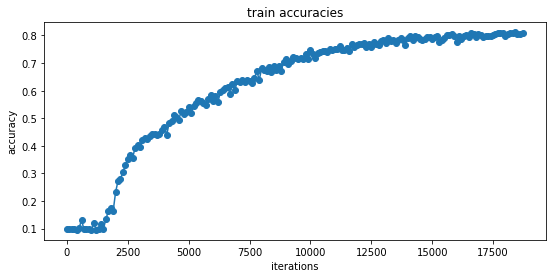

In [16]:
plt.title('train accuracies')
plt.plot(itr, acc_hist_part, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()